In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import decomposition
from sklearn.decomposition import FastICA
from sklearn import preprocessing
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, homogeneity_score, silhouette_score, classification_report
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve
import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset_select =     0    # 0 for wine , 1 for cancer

In [3]:
if dataset_select == 0:
    wine = pd.read_csv('data/wine.csv',sep=';')
    print('Wine Quality Dataset')
    print(wine.shape)
    bins = (2, 6.5, 8)
    group_names = ['bad','good']
    wine['quality'] = pd.cut(wine['quality'], bins=bins,labels=group_names)
    wine = wine.dropna()
    wine_label_quality = LabelEncoder()
    wine['quality'] = wine_label_quality.fit_transform(wine['quality'])
    df = wine
    X = wine.drop('quality',axis=1)
    y = wine['quality']
elif dataset_select == 1:
    print('Cancer Dataset')
    cancer = pd.read_csv('data/cancer.csv')
    print(cancer.shape)
    cancer = cancer.dropna()
    cancer['class']=cancer['class'].map({4:1, 2:0})
    df = cancer
    X = cancer.drop(['id','class'],axis=1)
    y = cancer['class'] 
else:
    raise Exception('dataset_select field must be 0 for wine , 1 for cancer')

min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

Wine Quality Dataset
(4898, 12)


In [5]:
ica_7 = FastICA(n_components=8, random_state=44)
ica_7.fit(X)
X_ica_7 = ica_7.transform(X)
#print(ica_7.explained_variance_ratio_ * 100)
#print(np.cumsum(ica_7.explained_variance_ratio_)*100)

In [6]:
plt.plot(np.cumsum(ica_7.explained_variance_ratio_))
plt.xlabel('Number Of Componnets')
plt.ylabel('Explained Variance')
plt.title('Variance vs # of Components')
plt.show()

AttributeError: 'FastICA' object has no attribute 'explained_variance_ratio_'

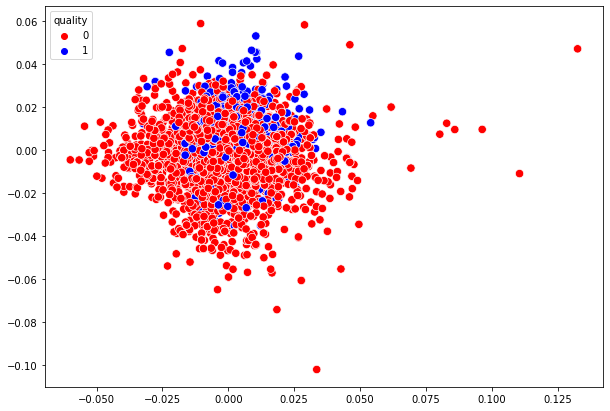

In [7]:
plt.figure(figsize=(10,7))
sns.scatterplot(x=X_ica_7[:, 0], y=X_ica_7[:,1], s = 70,
                hue=y, palette=['red','blue'])
plt.show()

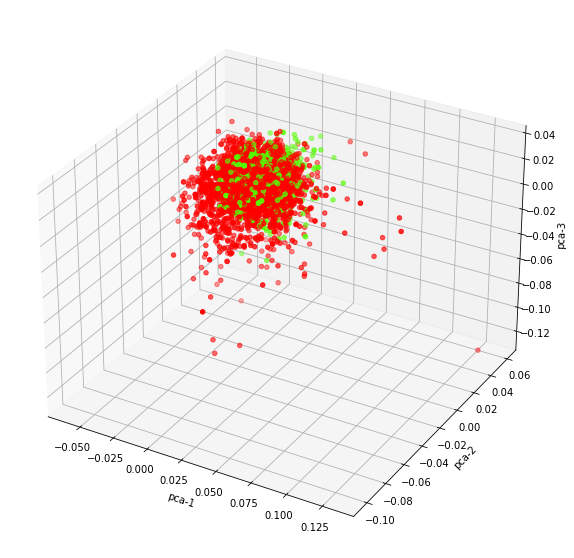

In [8]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=X_ica_7[:, 0], 
    ys=X_ica_7[:, 1], 
    zs=X_ica_7[:, 2], 
    c=y, 
    cmap='prism'
)
ax.set_xlabel('pca-1')
ax.set_ylabel('pca-2')
ax.set_zlabel('pca-3')
plt.show()

In [9]:
clusters = list(range(2,31,1))
silh = {}
homog = {}
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster, n_init=50, max_iter=1000, random_state=44, n_jobs=-2).fit(X_ica_7)
    label = kmeans.labels_
    sil_coeff = silhouette_score(X_ica_7, label, metric='euclidean')
    homog_score = homogeneity_score(y, label)
    silh[cluster] = sil_coeff
    homog[cluster] = homog_score
    ############################################### FIX #############################################
    #print("For n_clusters={}, The Silhouette Coefficient is {}".format(cluster, sil_coeff))
    #print("For n_clusters={}, The homogeneity_score is {}".format(cluster, homog_score))

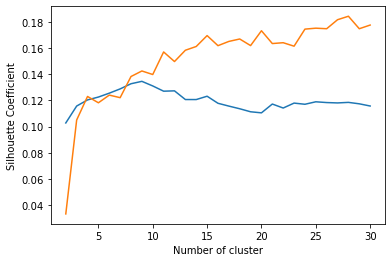

In [10]:
plt.figure()
plt.plot(list(silh.keys()), list(silh.values()))
plt.plot(list(homog.keys()), list(homog.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [11]:
silh_EM = {}
homog_EM = {}
log_likelihood_EM = {}
for cluster in clusters:
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=44, 
                          n_init=5).fit(X_ica_7)
    label = gmm.predict(X_ica_7)
    sil_coeff = silhouette_score(X_ica_7, label, metric='euclidean')
    homog_score = homogeneity_score(y, label)
    silh_EM[cluster] = sil_coeff
    homog_EM[cluster] = homog_score
    log_likelihood_EM[cluster] = gmm.score(X_ica_7)
    #print("For n_clusters={}, The Silhouette Coefficient is {}".format(cluster, sil_coeff))
    #print("For n_clusters={}, The homogeneity_score is {}".format(cluster, homog_score))
    #print("For n_clusters={}, The log_likelihood score is {}".format(cluster, log_likelihood_EM[cluster]))

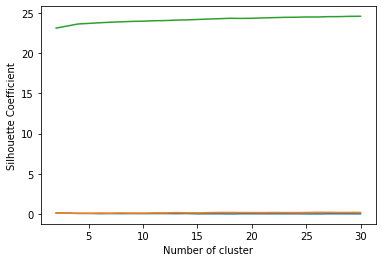

In [12]:
plt.figure()
plt.plot(list(silh_EM.keys()), list(silh_EM.values()))
plt.plot(list(homog_EM.keys()), list(homog_EM.values()))
plt.plot(list(log_likelihood_EM.keys()), list(log_likelihood_EM.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

Tuned Accuracy: 80.65%
[learning_curve] Training set sizes: [ 274  548  822 1096 1370 1644 1918 2192 2466 2740]


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  17 out of  50 | elapsed:   17.4s remaining:   33.8s
[Parallel(n_jobs=2)]: Done  34 out of  50 | elapsed:   32.7s remaining:   15.3s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   50.2s finished


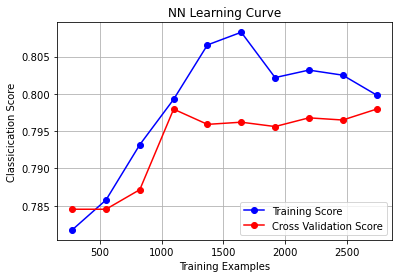

No handles with labels found to put in legend.


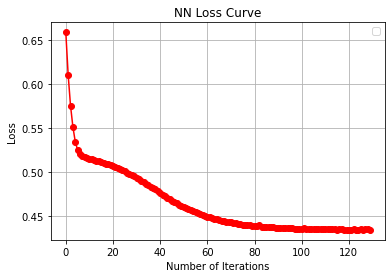

In [13]:
if dataset_select == 0:
    X_train, X_test, y_train, y_test = train_test_split(X_ica_7, 
                                                        y, 
                                                        test_size=0.3, 
                                                        random_state=42,
                                                        stratify=y)
    nn_clf = MLPClassifier()
    nn_clf.fit(X_train, y_train)
    nn_y_pred = nn_clf.predict(X_test)
    nn_acc = accuracy_score(y_test, nn_y_pred)*100
    print("Tuned Accuracy: %.2f%%"%nn_acc)
    train_sizes, nn_train_scores, test_scores = learning_curve(nn_clf,
                                                               X_train,
                                                               y_train,
                                                               train_sizes=np.linspace(0.1,1.0,10),
                                                               verbose=3,
                                                               n_jobs=2)
    plt.figure()
    plt.plot(train_sizes, np.mean(nn_train_scores, axis=1),'o-',
            label='Training Score',color='blue')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-',
            label='Cross Validation Score',color='red')
    plt.title('NN Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Classicication Score')
    plt.legend()
    plt.grid()
    #plt.savefig('img/NN_learning '+dataset+'.png')
    plt.show()
    nn_loss= nn_clf.loss_curve_
    plt.figure()
    plt.title('NN Loss Curve')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Loss')
    plt.plot(nn_loss, 'o-', color='red')
    plt.grid()
    plt.legend()
    #plt.savefig('img/NN_loss '+dataset+'.png')
    plt.show()